### Heartbeat Arrhythmia Detection with Convolutional Neural Networks at MIT-BIH dataset
---
##### Part 1.1
---
###### * Downloading dataset
###### * File manipulation

In [1]:
# Importing built-in libraries for file/path manipulation
import os
import glob

# Importing WFDB library for getting data from PhysioNet and reading files
from wfdb.io import get_dbs
from wfdb.io import dl_database

In [2]:
# Change current working directory
print("Directory before changing it: " + os.getcwd())
os.chdir("..")
print("Directory after changing it: " + os.getcwd())

Directory before changing it: C:\Users\omerf\PycharmProjects\arrhythmia-cnn\notebooks
Directory after changing it: C:\Users\omerf\PycharmProjects\arrhythmia-cnn


In [3]:
# Download data if it's not exist in data directory,
# otherwise download it from PhysioNet

if not os.path.exists("data/mitdb"):
    dbs = get_dbs()
    print(dbs)

    subs = 'MIT-BIH'
    res = [[index, sub_string] for index, sub_string in enumerate(dbs) if subs in sub_string[1]]
    print(res)
    os.mkdir("data/mitdb")
    dl_database('mitdb', dl_dir='data/mitdb')
else:
    print("Data directory exists")

Data directory exists


In [4]:
def get_file_paths():
    # Getting paths for records and annotations
    record_paths = glob.glob("data/mitdb/*.dat")
    annot_paths = glob.glob("data/mitdb/*.atr")
    hea_paths = glob.glob("data/mitdb/*.hea")

    # Sort lists
    record_paths.sort()
    annot_paths.sort()
    hea_paths.sort()
    # Create path dict
    p = {"rec_path": record_paths,
         "ann_path": annot_paths,
         "hea_path": hea_paths}

    return p

paths = get_file_paths()
# Throws error if total data file number is not equeal to other specs
try:
    if len(paths["rec_path"]) != len(paths["ann_path"]) != len(paths["hea_path"]):
        raise IOError

except IOError:
    print("Some data files are missing!")

In [5]:
# Importing WFDB plot functions, uses Matplotlib
from wfdb.io import rdann, rdrecord
from wfdb.plot import plot_wfdb

# Read 2 channel record and it's annotation
record = rdrecord(paths["rec_path"][0].split(".")[0], sampto=3000)
ann = rdann(paths["ann_path"][0].split(".")[0], "atr", sampto=3000)

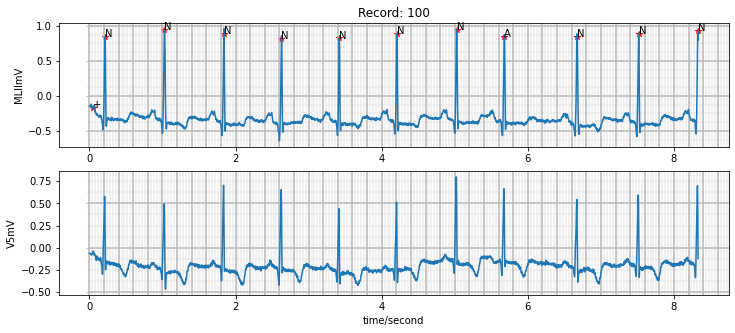

In [6]:
# Plot graph with grids
plot_wfdb(record=record, annotation=ann, plot_sym=True,
          time_units='seconds',
          figsize=(12, 5), ecg_grids='all')

---
##### Part 1.2
---
###### * Ploting raw data (Bar plot, pie chart etc.)
###### * Data analysis

In [7]:
# Import beat dictionary
from data import beat_ann

def get_beat_count_dict():
    # Create empty dictionary to hold all count values
    bc_dict = {}
    # Take all patients in annotation lists
    for patient in range(len(paths["ann_path"])):
        annot = rdann(paths["ann_path"][patient].split(".")[0], "atr")
        # Take all beats
        for beat_type in annot.symbol:
            # Check if beat type is in pre-defined beat dictionary
            if beat_type in beat_ann:
                # If dictionary does not include that beat type create a key-value pair and assign to 1
                if beat_type not in bc_dict.keys():
                    bc_dict[beat_type] = 1
                # Otherwise add 1 to value of matched beat type
                else:
                    bc_dict[beat_type] += 1

    return bc_dict

beat_count_dict = get_beat_count_dict()

In [8]:
# Importing NumPy
import numpy as np
from data import b_to_sb

def get_sb_list():
    sbl = []
    count_labels, count_values = np.array(list(beat_count_dict.items())).T

    for beat_type in list(b_to_sb.keys()):
        sbl.append([beat_type,
                    count_values[list(count_labels).index(beat_type)],
                    b_to_sb[beat_type]])

    # List contains beat types, beat counts and super beat classes according to its order
    sbl = np.array(sbl)
    return sbl

sb_list = get_sb_list()

In [9]:
# Importing Seaborn and Matplotlib.PyPlot to plot graphs
import seaborn as sns
import matplotlib.pyplot as plt
# Importing Matplotlib.Patches to create custom legends
import matplotlib.patches as mpatches

# Importing only super class names
from data import sb_ann_palette, sb_ann_class, sb_ann_class_palette, sb_ann

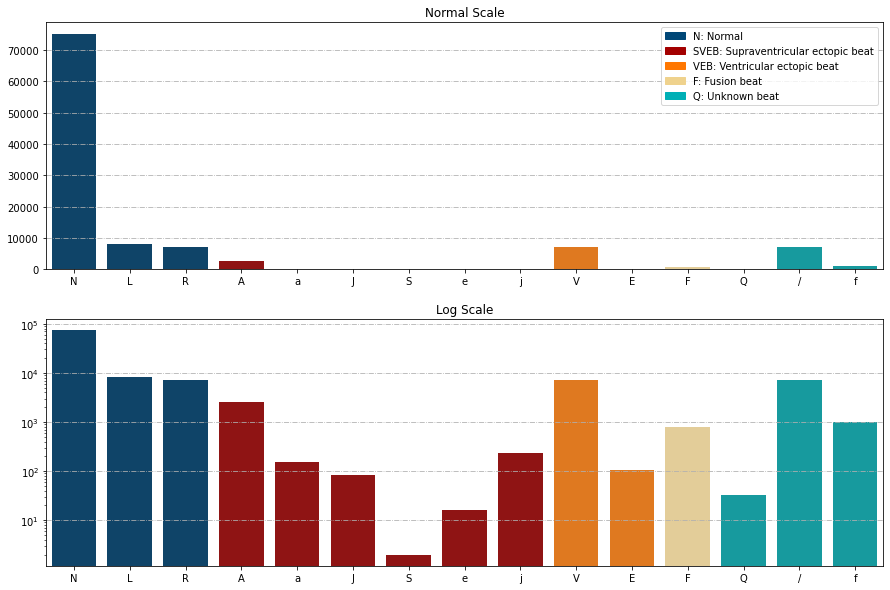

In [10]:
# Creating bar plot figure with specified size
def draw_barplot_sb_class():
    fig, (norm_ax, log_ax) = plt.subplots(2, figsize=(15, 10))
    # Defining legend patches for superior arrythmia classes
    patch_list = [mpatches.Patch(color=p, label=l + ": " + sb_ann[l]) for p, l in zip(sb_ann_class_palette, sb_ann_class)]

    sns.barplot(sb_list[:, 0], sb_list[:, 1], palette=sb_ann_palette, ax=norm_ax)
    # Setting y-axis to normal scale and adding horizontal grid
    norm_ax.grid(True, axis="y", which="major", ls="-.")
    norm_ax.set_title("Normal Scale")
    # Implementing custom legend
    _ = norm_ax.legend(handles=patch_list)
    # Show the plot

    # Ploting bar plot with seaborn
    sns.barplot(sb_list[:, 0], sb_list[:, 1], palette=sb_ann_palette, ax=log_ax)
    # Setting y-axis to logarithmic scale and adding horizontal grid
    log_ax.set_yscale("log")
    log_ax.grid(True, axis="y", which="major", ls="-.")
    log_ax.set_title("Log Scale")

    plt.show()

draw_barplot_sb_class()

In [11]:
# Printing beat names and counts
def print_instance_counts():
    print("Instance Count\t|\tAnnotation (Super Beat)")
    for i, c, s in np.array(sb_list[:,:]):
        print(f"{c}\t\t|\t{i}: {beat_ann[i]} ({s})")
print_instance_counts()

Instance Count	|	Annotation (Super Beat)
75052		|	N: Normal beat (N)
8075		|	L: Left bundle branch block beat (N)
7259		|	R: Right bundle branch block beat (N)
2546		|	A: Atrial premature beat (SVEB)
150		|	a: Aberrated atrial premature beat (SVEB)
83		|	J: Nodal (junctional) premature beat} (SVEB)
2		|	S: Supraventricular premature or ectopic beat (atrial or nodal) (SVEB)
16		|	e: Atrial escape beat (SVEB)
229		|	j: Nodal (junctional) escape beat (SVEB)
7130		|	V: Premature ventricular contraction (VEB)
106		|	E: Ventricular escape beat (VEB)
803		|	F: Fusion of ventricular and normal beat (F)
33		|	Q: Unclassifiable beat (Q)
7028		|	/: Paced beat (Q)
982		|	f: Fusion of paced and normal beat (Q)


In [12]:
# Calculate total super beat instances
def get_sb_instances():
    sbeat_count_dict = {}
    for sb in sb_ann_class:
        cnt = 0
        for c, b in np.array(sb_list)[:, 1:]:
            if sb == b:
                cnt += int(c)
        sbeat_count_dict[sb] = cnt

    return sbeat_count_dict

sb_count_dict = get_sb_instances()

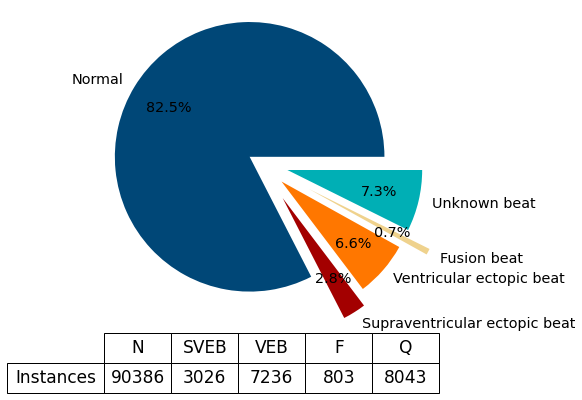

In [13]:
# Creating pie chart figure with specified size
def draw_pie_chart_sb_class():
    # Set figure size
    plt.figure(figsize=(6, 6))
    # Total super beat class instances
    total = sum(list(sb_count_dict.values()))
    # Divide all super beat class instances to total beat number to define pie chart percentage row values
    sizes = [(size / total) * 100 for size in list(sb_count_dict.values())]
    # Set pie chart class parts explode
    explode = (0.1, 0.3, 0.2, 0.4, 0.2)
    # Draw pie chart
    plt.pie(sizes, explode=explode, labels=list(sb_ann.values()), autopct='%1.1f%%',
            pctdistance=0.7, textprops={"fontsize": "x-large"}, colors=sb_ann_class_palette,
            shadow=False, startangle=0)
    # Setting all axis to equal to get perfect circular pie chart
    plt.axis('equal')
    # Define row values of table plot
    rows = [[str(integer) for integer in list(sb_count_dict.values())]]
    row_label = ["Instances"]
    # Defining column headers of table plot
    cols = tuple(sb_count_dict.keys())
    # Draw table
    table = plt.table(cellText=rows,
                      colLabels=cols,
                      rowLabels=row_label,
                      loc="bottom",
                      cellLoc="center",
                      rowLoc="center",
                      colLoc="center")
    # Scale table and font size
    table.scale(1, 2.5)
    table.set_fontsize(20)
    # Show the plot
    plt.show()

draw_pie_chart_sb_class()

---
##### Part 1.3
---
###### * Find optimized beat width

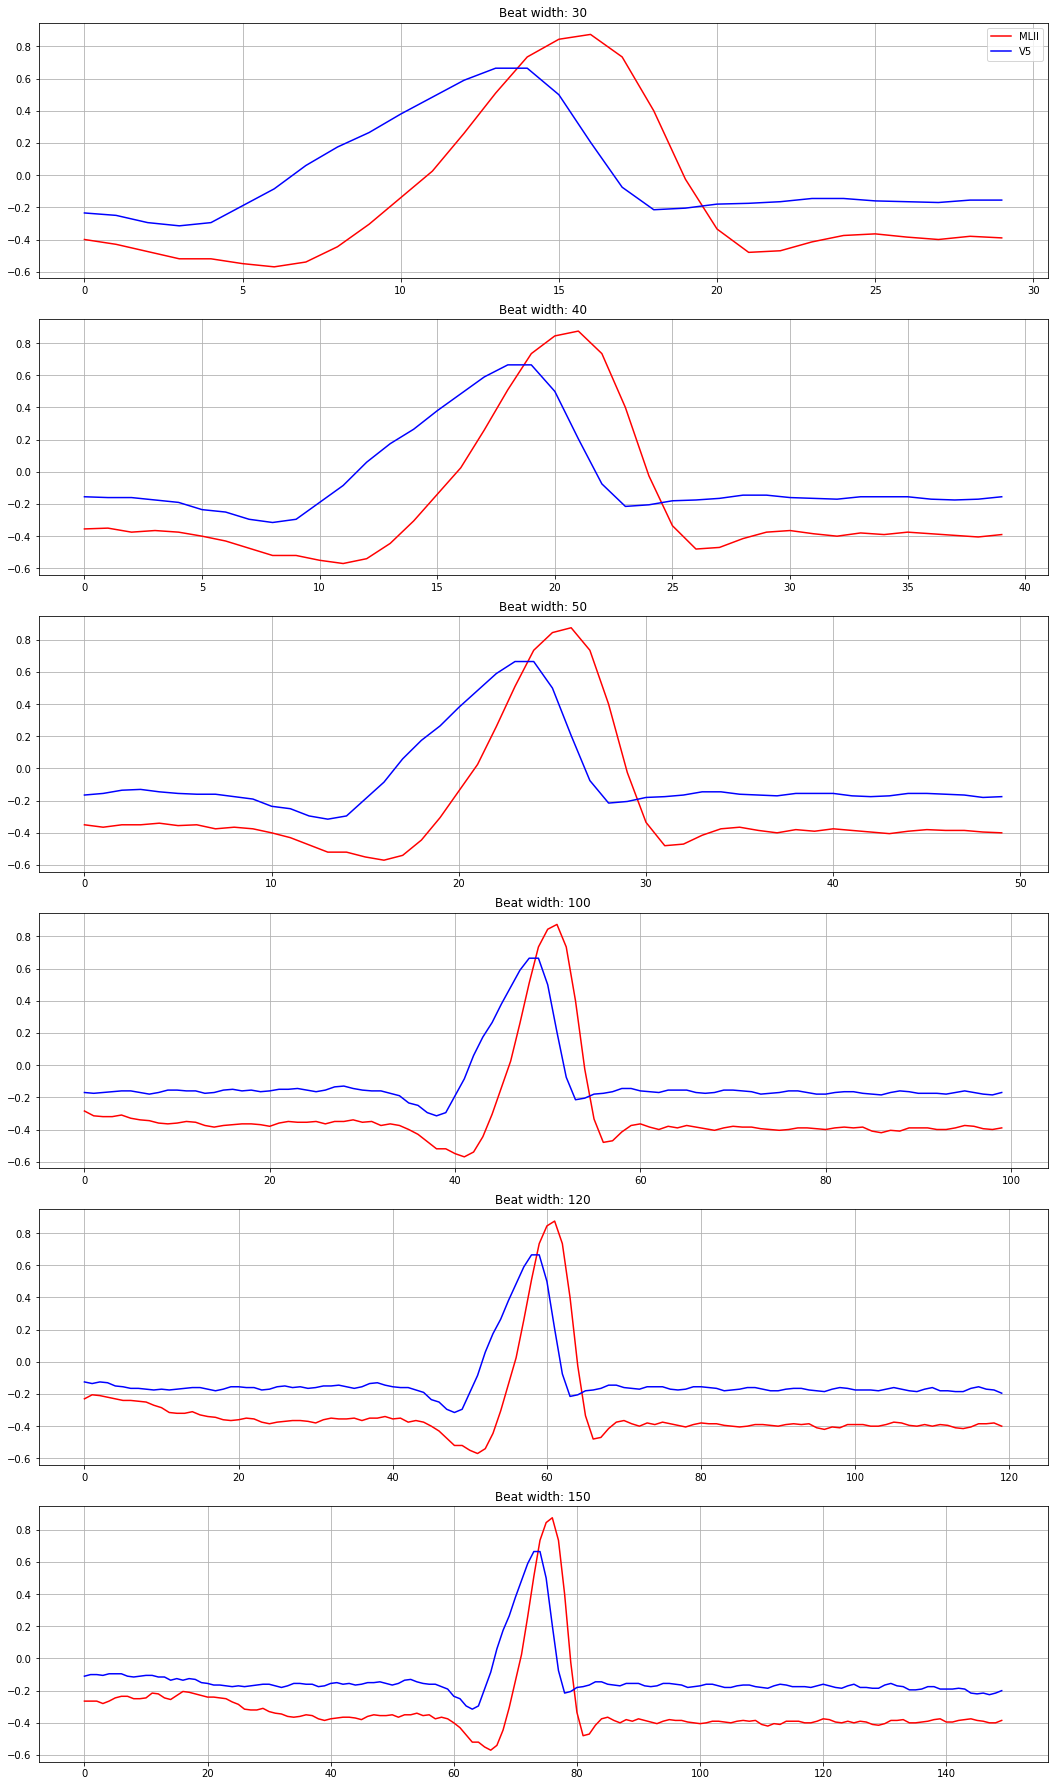

In [14]:
# Take random beat and compare different beat widths
def plot_beat_comparison(beat_list):
    fig, axes = plt.subplots(nrows=len(beat_list), ncols=1, figsize=(15, 25))
    fig.tight_layout(pad=2.0)

    for ax, width in zip(axes, beat_list):
        ax.plot(record.p_signal[ann.sample[8] - width // 2:
                                ann.sample[8] + width // 2, 0], "r",
                record.p_signal[ann.sample[8] - width // 2:
                                ann.sample[8] + width // 2, 1], "b")
        ax.set_title(f"Beat width: {width}")
        ax.grid(True)
    axes[0].legend(record.sig_name)
    plt.show(fig)

beat_width_list = [30, 40, 50, 100, 120, 150]
plot_beat_comparison(beat_width_list)

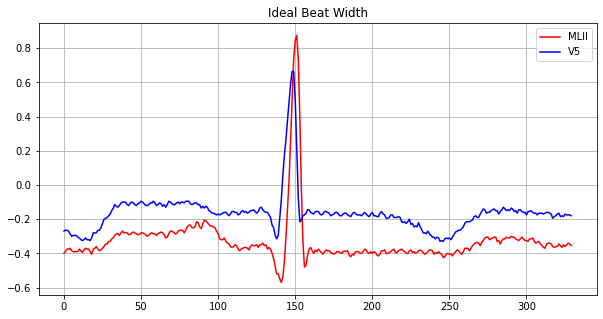

In [15]:
# Plotting ideal beat width
def plot_ideal_beat_width(beat_list):

    fig = plt.figure(figsize=(10, 5))
    plt.plot(record.p_signal[ann.sample[8] - beat_list[0]:
                             ann.sample[8] + beat_list[1], 0], "r",
             record.p_signal[ann.sample[8] - beat_list[0]:
                             ann.sample[8] + beat_list[1], 1], "b",
             figure=fig)

    plt.title("Ideal Beat Width")
    plt.legend(record.sig_name)
    plt.grid(True)
    plt.show(fig)

# 150 sample before and 180 sample after from center point of the beat
beat_width = [150, 180]
plot_ideal_beat_width(beat_width)


---
##### Part 1.4
---
###### * Data split into train and test
###### * Distribution analysis

In [16]:
import random

def train_test_split(train_ratio=0.7):
    x = []
    y = []
    n_count = 0
    for rec_path, ann_path in zip(paths["rec_path"], paths["ann_path"]):
        rec = rdrecord(rec_path.split(".")[0])
        an = rdann(ann_path.split(".")[0], "atr")
        for beat, symbol in zip(an.sample[2:-2], an.symbol[2: -2]):
            if symbol in list(beat_count_dict.keys()):
                if symbol is "N" and n_count < 10000:
                    n_count += 1
                    x.append([rec.p_signal[beat - beat_width[0]: beat + beat_width[1]]])
                    y.append(b_to_sb[symbol])
                elif symbol is not "N":
                    x.append([rec.p_signal[beat - beat_width[0]: beat + beat_width[1]]])
                    y.append(b_to_sb[symbol])

    random.seed(0)
    random.shuffle(x)
    random.seed(0)
    random.shuffle(y)

    x_tr, x_te = x[: int(len(x) * train_ratio)], x[int(len(x) * train_ratio):]
    y_tr, y_te = y[: int(len(y) * train_ratio)], y[int(len(y) * train_ratio):]

    return np.array(x_tr).squeeze(), np.array(x_te).squeeze(), \
           np.array(y_tr).squeeze(), np.array(y_te).squeeze()

X_train, X_test, y_train, y_test = train_test_split(0.8)

In [17]:
def get_train_test_count():
    tr_list = [[i, list(y_train).count(i)] for i in set(list(y_train))]
    te_list = [[k, list(y_test).count(k)] for k in set(list(y_test))]
    te_list.sort(key = lambda i: sb_ann_class.index(i[0]))
    tr_list.sort(key = lambda i: sb_ann_class.index(i[0]))
    return np.array(tr_list), np.array(te_list)

train_list, test_list = get_train_test_count()

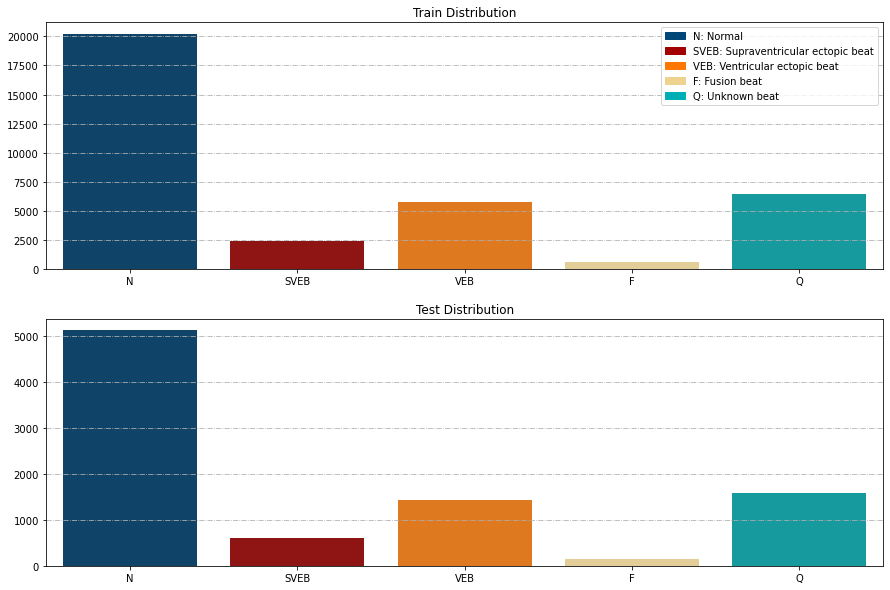

In [18]:
# Creating bar plot figure with specified size
def draw_barplot_train_test():
    fig, (train_ax, test_ax) = plt.subplots(2, figsize=(15, 10))
    # Defining legend patches for superior arrythmia classes
    patch_list = [mpatches.Patch(color=p, label=l + ": " + sb_ann[l]) for p, l in zip(sb_ann_class_palette, sb_ann_class)]

    sns.barplot(train_list[:, 0], train_list[:, 1], palette=sb_ann_class_palette, ax=train_ax)
    # Setting y-axis to normal scale and adding horizontal grid
    train_ax.grid(True, axis="y", which="major", ls="-.")
    train_ax.set_title("Train Distribution")
    # Implementing custom legend
    _ = train_ax.legend(handles=patch_list)
    # Show the plot

    # Ploting bar plot with seaborn
    sns.barplot(test_list[:, 0], test_list[:, 1], palette=sb_ann_class_palette, ax=test_ax)
    # Setting y-axis to normal scale and adding horizontal grid
    test_ax.grid(True, axis="y", which="major", ls="-.")
    test_ax.set_title("Test Distribution")

    plt.show()

draw_barplot_train_test()

---
##### Part 2.1
---
###### * Model creation

In [19]:
# Pre-defined model parameters

epoch = 20
batch_size = 50

In [22]:
# Importing signal libraries
import scipy as sp
# and deep learning frameworks to creating deep learning model for classification and recognition
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.layers import Conv1D, AvgPool1D
from tensorflow.keras.layers import Dropout

inp = Input(shape=(330, 2), name="input")

conv1_1 = Conv1D(32, 11, activation="relu", name="conv1_1")(inp)
conv1_2 = Conv1D(64, 11, activation="relu", name="conv1_2")(conv1_1)

av_pool_1 = AvgPool1D(pool_size=2, strides=2, name="average_pool_1")(conv1_2)

conv1_3 = Conv1D(128, 9, activation="relu", name="conv1_3")(av_pool_1)
conv1_5 = Conv1D(256, 9, activation="relu", name="conv1_5")(conv1_3)

av_pool_2 = AvgPool1D(pool_size=2, strides=2, name="average_pool_2")(conv1_5)

conv1_6 = Conv1D(256, 7, activation="relu", name="conv1_6")(av_pool_2)
conv1_7 = Conv1D(256, 7, activation="relu", name="conv1_7")(conv1_6)

av_pool_3 = AvgPool1D(pool_size=2, strides=2, name="average_pool_3")(conv1_7)

conv1_8 = Conv1D(512, 5, activation="relu", name="conv1_8")(av_pool_3)
conv1_9 = Conv1D(512, 5, activation="relu", name="conv1_9")(conv1_8)

flat = Flatten(name="flatten")(conv1_9)

dense_1 = Dense(1024, activation="relu", name="dense_1")(flat)
drop_1 = Dropout(0.2, name="dropout_1")(dense_1)

dense_2 = Dense(512, activation="relu", name="dense_2")(drop_1)
drop_2 = Dropout(0.2, name="dropout_2")(dense_2)

dense_3 = Dense(256, activation="relu", name="dense_3")(drop_2)
drop_3 = Dropout(0.2, name="dropout_3")(dense_3)

dense_4 = Dense(128, activation="relu", name="dense_4")(drop_3)
drop_4 = Dropout(0.2, name="dropout_4")(dense_4)

dense_5 = Dense(64, activation="relu", name="dense_5")(drop_4)
drop_5 = Dropout(0.2, name="dropout_5")(dense_5)

out = Dense(5, activation="softmax", name="dense_6_out")(drop_5)

model = Model(inputs=inp, outputs=out, name="arr-cnn")
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "arr-cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 330, 2)]          0         
_________________________________________________________________
conv1_1 (Conv1D)             (None, 320, 32)           736       
_________________________________________________________________
conv1_2 (Conv1D)             (None, 310, 64)           22592     
_________________________________________________________________
average_pool_1 (AveragePooli (None, 155, 64)           0         
_________________________________________________________________
conv1_3 (Conv1D)             (None, 147, 128)          73856     
_________________________________________________________________
conv1_5 (Conv1D)             (None, 139, 256)          295168    
_________________________________________________________________
average_pool_2 (AveragePooli (None, 69, 256)           0   